<a href="https://colab.research.google.com/github/sambitdash/EVA-2/blob/master/Phase-2/Session-2/EVA_P2S2_File_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 2 - File 0

## Import the Libraries

Force usage of Tensorflow 1. All indentation modified to 4 for easier reading of the code.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

## Utility Method for Matrix Conversion 

Prediction of the (step+1)-th element on the array given the RNN input of first step elements. Effectively, the RNN must learn the sinusoidal function and prediction plot will be kind of a subsampling of the time series predicting the (step+1)-th element of the sequence.

In [2]:
# convert into dataset matrix
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

## Create Random Data in DataFrame

Data is a sinusoidal wave function that's also added a random noise of -1 to 1. The first 5 elements are shown are printed as a sample. 3 cycles of sinusoidal waves are considered as $(1000\times0.02/2\pi) = 3.18309886184$  are considered. 

In [3]:
step = 4
N = 1000
Tp = 800    

t=np.arange(0,N)
x=np.sin(0.02*t) + 2*np.random.rand(N)
df = pd.DataFrame(x)
df.head()

,0
0,0.571651
1,0.957093
2,1.230348
3,0.591365
4,1.998969


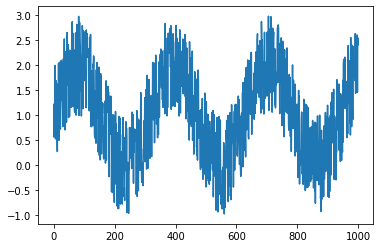

In [4]:
plt.plot(df)
plt.show()

In [5]:
values=df.values
train,test = values[0:Tp,:], values[Tp:N,:]

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))
 
trainX,trainY =convertToMatrix(train,step)
testX,testY = convertToMatrix(test,step)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Model Design

RNNs are designed as a sequence with $ o = h = tanh(WX + Uh + b) $

The parameters are computed from the unrolling of the RNN-states. There are 32-variables for the W. And since, there the total paramters will be $ units\times(units+states+bias) = 32\times(32+4+1) = 1184 $

Output of RNN will 32 paramater array which will be pushed into a Dense layer of 8 units. Leading to $32\times8 + (biases=8) = 264$ parameters.

Dense 8 to 1 will have 9 parameters.

$ReLu$ seems to produce better convergence than $tanh$ and one argument can be better gradient flow in case of $ReLu$ activation. 


In [6]:
model = Sequential()
model.add(SimpleRNN(units=32, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1184      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,457
Trainable params: 1,457
Non-trainable params: 0
_________________________________________________________________


## Training

Batch sizes are kept as 16 which is essentially ensuring at a times 16 sets of sequences are picked up for training in a batch. 

In [7]:
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

Train on 800 samples
Epoch 1/100
800/800 - 1s - loss: 1.7326
Epoch 2/100
800/800 - 0s - loss: 0.4522
Epoch 3/100
800/800 - 0s - loss: 0.4212
Epoch 4/100
800/800 - 0s - loss: 0.4119
Epoch 5/100
800/800 - 0s - loss: 0.4063
Epoch 6/100
800/800 - 0s - loss: 0.4061
Epoch 7/100
800/800 - 0s - loss: 0.4042
Epoch 8/100
800/800 - 0s - loss: 0.4015
Epoch 9/100
800/800 - 0s - loss: 0.3985
Epoch 10/100
800/800 - 0s - loss: 0.3979
Epoch 11/100
800/800 - 0s - loss: 0.3953
Epoch 12/100
800/800 - 0s - loss: 0.3949
Epoch 13/100
800/800 - 0s - loss: 0.3931
Epoch 14/100
800/800 - 0s - loss: 0.3932
Epoch 15/100
800/800 - 0s - loss: 0.3940
Epoch 16/100
800/800 - 0s - loss: 0.3897
Epoch 17/100
800/800 - 0s - loss: 0.3929
Epoch 18/100
800/800 - 0s - loss: 0.3896
Epoch 19/100
800/800 - 0s - loss: 0.3879
Epoch 20/100
800/800 - 0s - loss: 0.3888
Epoch 21/100
800/800 - 0s - loss: 0.3872
Epoch 22/100
800/800 - 0s - loss: 0.3884
Epoch 23/100
800/800 - 0s - loss: 0.3863
Epoch 24/100
800/800 - 0s - loss: 0.3856
Epoc

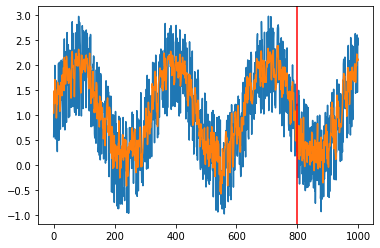

In [8]:
index = df.index.values
plt.plot(index,df)
plt.plot(index,predicted)
plt.axvline(df.index[Tp], c="r")
plt.show()

In [9]:
!nvidia-smi

Tue Feb  4 03:12:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 107...  On   | 00000000:08:00.0  On |                  N/A |
|  0%   53C    P5    15W / 180W |   7877MiB /  8116MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  